
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [1]:
using Printf, Pkg
using MLPreprocessing
using ScikitLearn
using RDatasets, LIBSVM
using MLDataUtils
using MLMetrics
using MLDataPattern
using LearnBase
using ClassImbalance

In [2]:
using CSV, DataFrames, Statistics, Dates, Gadfly

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/macbookpro/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [3]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [4]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [5]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [6]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


#### Exclusion des lignes où :SURVERSE est manquante

In [7]:
surverse_df = dropmissing(data, disallowmissing=true)
first(surverse_df,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


##### Point important à noter pour la suite: les cas négatifs sont beaucoup plus présents que les cas positifs.

In [8]:
# Proportion de positifs : 
positifs = filter(row -> row.SURVERSE == 1, surverse_df)
size_p = size(positifs, 1)

# Proportion de négatifs :
negatifs = filter(row -> row.SURVERSE == 0, surverse_df)
size_n = size(negatifs, 1)

p_positifs = size_p/size(surverse_df, 1)
p_negatifs = size_n/size(surverse_df, 1)

print("Il y a $size_p cas positifs et $size_n cas négatifs \n")
print("La proportion de posistifs est de : $p_positifs \n")
print("La proportion de négatifs est de: $p_negatifs")

Il y a 5636 cas positifs et 155462 cas négatifs 
La proportion de posistifs est de : 0.03498491601385492 
La proportion de négatifs est de: 0.9650150839861451

## Chargement des précipitations

In [9]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [10]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


In [11]:
filter( row -> row.SURVERSE == 1 && row.NO_OUVRAGE == "0801-05D", surverse_df)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0801-05D,2013-05-03,1
2,0801-05D,2013-05-06,1
3,0801-05D,2013-05-11,1
4,0801-05D,2013-05-16,1
5,0801-05D,2013-05-23,1
6,0801-05D,2013-05-24,1
7,0801-05D,2013-05-25,1
8,0801-05D,2013-05-28,1
9,0801-05D,2013-05-29,1


# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [12]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)
first(pcp_sum ,20)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,missing
2,2013-05-02,0,0,0,0,missing
3,2013-05-03,0,0,0,0,missing
4,2013-05-04,0,0,0,0,missing
5,2013-05-05,0,0,0,0,missing
6,2013-05-06,0,0,0,0,missing
7,2013-05-07,0,0,0,0,missing
8,2013-05-08,0,0,0,0,missing
9,2013-05-09,10,0,19,0,missing


#### Extraction du taux horaire journalier maximum des précipitations pour chacune des stations météorologiques

In [13]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,missing
2,2013-05-02,0,0,0,0,missing
3,2013-05-03,0,0,0,0,missing
4,2013-05-04,0,0,0,0,missing
5,2013-05-05,0,0,0,0,missing


#### Beaucoup de missing sont présents pour chaque colonne :

In [14]:
missings_pcp_sum = [sum(ismissing.(col)) for col in eachcol(pcp_sum)]

print("Nombre de valeurs missing par colonne: $missings_pcp_sum")

Nombre de valeurs missing par colonne: [0, 100, 190, 107, 37, 234]

On va essayer de remédier à celà : Si une ligne contient une colonne missing,
on va la remplacer par la moyenne de toutes les autres colonnes qui ne sont pas missing.

In [15]:
# si row contient une valeur missing, la fonction remplace missing
# par la moyenne des autres valeurs qui ne sont pas missing
function average_on_missing(row::DataFrameRow)

    row_size = size(row, 1)
    count_missing = 0
    missing_indexes = zeros(Int8, row_size)
    
    for i = 1:row_size
         if row[i] === missing 
             count_missing += 1
             missing_indexes[i] = 1
         end
     end
     
    if count_missing != 0 && count_missing != row_size
         mean = 0
         for i = 1:row_size
             if missing_indexes[i] == 0
                 mean += row[i]
             end
         end
         mean = mean / (row_size - count_missing)
         for i = 1:row_size
             if missing_indexes[i] == 1
                 row[i] = floor(Int64, mean)
             end
         end
    end
end

average_on_missing (generic function with 1 method)

In [16]:
for row in eachrow(pcp_sum)
    average_on_missing(row[2:end])
end
for row in eachrow(pcp_max)
    average_on_missing(row[2:end])
end

Nous réduisons donc considérablement les valeurs missings en faisant la supposition que les valeurs missing ne devraient pas trop être eloignées de la moyenne pour chaque ligne.

In [17]:
missings_pcp_sum = [sum(ismissing.(col)) for col in eachcol(pcp_sum)]

print("Nombre de valeurs missing par colonne: $missings_pcp_sum")

Nombre de valeurs missing par colonne: [0, 3, 3, 3, 3, 3]

# Construction des variables explicatives

Pour les 5 ouvrages demandés, nous les avons localisé sur une carte. Ensuite nous avons pris les stations pluviométrique les plus proches
pour ensuite faire une moyenne.
Donc pour chaque ouvrage, nous avons : 
<ul>
    <li> x₁ correspond à la moyenne des sommes journalières des précipitations des stations pluviométriques les plus proches. 
    </li>
    <li> x₂ correspond à la moyenne des taux horaires maximum journaliers des précipitations des stations pluviométriques les plus proches. 
    </li>
    <li> x₃ correspond à la moyenne des taux horaires maximum journaliers des 5 stations pluviométriques.
    </li>
     <li> x₄ correspond à la moyenne des sommes journalières des 5 stations pluviométriques.
    </li>
</ul>

In [18]:
function vieux_port(df::DataFrame, pos::Int64)
    Xᵢ = Array{Union{Float64, Missing}}(missing, 4)

    ind = findfirst(pcp_sum[:,:date] .== df[pos,:DATE])
    Xᵢ[1] = pcp_sum[ind,:McTavish]
    Xᵢ[4] = ( pcp_sum[ind,:McTavish] + pcp_sum[ind,:StHubert] + pcp_sum[ind,:Assomption] +
              pcp_sum[ind,:Trudeau]  + pcp_sum[ind,:Bellevue] ) / 5
    
    ind = findfirst(pcp_max[:,:date] .== df[pos,:DATE])
    Xᵢ[2] = pcp_max[ind,:McTavish]
    Xᵢ[3] = ( pcp_max[ind,:McTavish] + pcp_max[ind,:StHubert] + pcp_max[ind,:Assomption] +
              pcp_max[ind,:Trudeau] + pcp_max[ind,:Bellevue] ) / 5
    return Xᵢ
end

vieux_port (generic function with 1 method)

In [19]:
#cette ouvrage ne se situe pas près d'une station pluviométrique en particulier
#On prend donc la moyenne des 3 stations les plus proches.
function rivieres_prairies(df::DataFrame, pos::Int64)
    Xᵢ = Array{Union{Float64, Missing}}(missing, 4)
    ind = findfirst(pcp_sum[:,:date] .== df[pos,:DATE])
    Xᵢ[1] = ((pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert]  + pcp_sum[ind, :Assomption])/ 3)
    Xᵢ[4] = (pcp_sum[ind,:McTavish] + pcp_sum[ind,:StHubert] + pcp_sum[ind,:Assomption] 
                + pcp_sum[ind,:Trudeau] + pcp_sum[ind,:Bellevue] ) / 5
    
    ind = findfirst(pcp_max[:,:date] .== df[pos,:DATE])
    Xᵢ[2] = ((pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] ) / 3)
    Xᵢ[3] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
                pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    return Xᵢ
end

rivieres_prairies (generic function with 1 method)

In [20]:
# Pareil que pour rivières des prairies
function pointe_trembles(df::DataFrame, pos::Int64)
    Xᵢ = Array{Union{Float64, Missing}}(missing, 4)
    ind = findfirst(pcp_sum[:,:date] .== df[pos,:DATE])
    Xᵢ[1] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert] + pcp_sum[ind, :Assomption])/3
    Xᵢ[4] = (pcp_sum[ind,:McTavish] + pcp_sum[ind,:StHubert] + pcp_sum[ind,:Assomption] 
                + pcp_sum[ind,:Trudeau] + pcp_sum[ind,:Bellevue] ) / 5
    
    ind = findfirst(pcp_max[:,:date] .== df[pos,:DATE])
    Xᵢ[2] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption])/3
    Xᵢ[3] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue]) / 5
    return Xᵢ
end

pointe_trembles (generic function with 1 method)

In [21]:
function ahunstic(df::DataFrame, pos::Int64)
    Xᵢ = Array{Union{Float64, Missing}}(missing, 4)
    ind = findfirst(pcp_sum[:,:date] .== df[pos,:DATE])
    Xᵢ[1] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :Trudeau])/2
    Xᵢ[4] = (pcp_sum[ind,:McTavish] + pcp_sum[ind,:StHubert] + pcp_sum[ind,:Assomption] 
                + pcp_sum[ind,:Trudeau] + pcp_sum[ind,:Bellevue] ) / 5
    
    ind = findfirst(pcp_max[:,:date] .== df[pos,:DATE])
    Xᵢ[2] = (pcp_max[ind,:McTavish] + pcp_max[ind, :Trudeau])/2
    Xᵢ[3] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    return Xᵢ
end

ahunstic (generic function with 1 method)

In [22]:
function verdun(df::DataFrame, pos::Int64)
    Xᵢ = Array{Union{Float64, Missing}}(missing, 4)
    ind = findfirst(pcp_sum[:,:date] .== df[pos,:DATE])
    Xᵢ[1] = (pcp_sum[ind,:McTavish] + pcp_sum[ind, :StHubert])/2
    Xᵢ[4] = (pcp_sum[ind,:McTavish] + pcp_sum[ind,:StHubert] + pcp_sum[ind,:Assomption] 
                + pcp_sum[ind,:Trudeau] + pcp_sum[ind,:Bellevue] ) / 5
    
    ind = findfirst(pcp_max[:,:date] .== df[pos,:DATE])
    Xᵢ[2] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert])/2
    Xᵢ[3] = (pcp_max[ind,:McTavish] + pcp_max[ind, :StHubert] + pcp_max[ind, :Assomption] +
            pcp_max[ind, :Trudeau] + pcp_max[ind, :Bellevue] ) / 5
    return Xᵢ 
end

verdun (generic function with 1 method)

Pour chaque ouvrage, on va construire un modèle propre à lui, en se basant sur les variables explicatives décrites plus haut:

In [23]:
moyennes = []
variances = []

dict = Dict("4350-01D" => vieux_port, "3260-01D" => rivieres_prairies, "4240-01D" => pointe_trembles,
            "3350-07D" => ahunstic, "4380-01D" => verdun, "0801-05D" => vieux_port)

ouvrage_to_cat = Dict("4350-01D" => [1, 0, 0, 0, 0, 0],
                      "3260-01D" => [0, 1, 0, 0, 0, 0],
                      "4240-01D" => [0, 0, 1, 0, 0, 0],
                      "3350-07D" => [0, 0, 0, 1, 0, 0],
                      "4380-01D" => [0, 0, 0, 0, 1, 0],
                      "0801-05D" => [0, 0, 0, 0, 0, 1])

ouvrages = ["4350-01D", "3260-01D", "4240-01D", "3350-07D", "4380-01D", "0801-05D"]
dataframes = Dict()

for ouvrage in ouvrages
    df = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)
    X = Matrix{Union{Missing, Float64}}(undef, size(df, 1), 4)
    for i=1:size(df,1)
        X[i,:] = dict[ouvrage](df, i)
    end
    
    df[!,:SUM] = X[:, 1]
    df[!,:MAX] = X[:, 2]
    df[!,:MOYENNE_MAX] = X[:, 3]
    df[!, :MOYENNE_SUM] = X[:, 4]
    df[!, :V1] .= ouvrage_to_cat[ouvrage][1]
    df[!, :V2] .= ouvrage_to_cat[ouvrage][2]
    df[!, :V3] .= ouvrage_to_cat[ouvrage][3]
    df[!, :V4] .= ouvrage_to_cat[ouvrage][4]
    df[!, :V5] .= ouvrage_to_cat[ouvrage][5]
    df[!, :V6] .= ouvrage_to_cat[ouvrage][6]
    dropmissing!(df, [:SUM, :MAX, :MOYENNE_MAX, :MOYENNE_SUM],disallowmissing=true)
    dataframes[ouvrage] = df
end


merged_X = [dataframes["4350-01D"];
            dataframes["3260-01D"];
            dataframes["4240-01D"];
            dataframes["3350-07D"];
            dataframes["4380-01D"];
            dataframes["0801-05D"]]

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX,MOYENNE_MAX,MOYENNE_SUM,V1
,String,Date,Int64,Float64,Float64,Float64,Float64,Int64
1,4350-01D,2013-05-01,0,0.0,0.0,0.0,0.0,1
2,4350-01D,2013-05-02,0,0.0,0.0,0.0,0.0,1
3,4350-01D,2013-05-03,0,0.0,0.0,0.0,0.0,1
4,4350-01D,2013-05-04,0,0.0,0.0,0.0,0.0,1
5,4350-01D,2013-05-05,0,0.0,0.0,0.0,0.0,1
6,4350-01D,2013-05-06,0,0.0,0.0,0.0,0.0,1
7,4350-01D,2013-05-07,0,0.0,0.0,0.0,0.0,1
8,4350-01D,2013-05-08,0,0.0,0.0,0.0,0.0,1
9,4350-01D,2013-05-09,0,10.0,10.0,7.2,7.2,1


#### On va enregistrer les moyennes et variances de chaque variable explicative et standardiser ces variables.

In [24]:
moyennes_dict = Dict()
variances_dict = Dict()

for ouvrage in ouvrages
    variables = dataframes[ouvrage][:, 4:7]
    moyennes = [mean(col) for col in eachcol(variables)]
    variances = [std(col) for col in eachcol(variables)]
    moyennes_dict[ouvrage] = moyennes
    variances_dict[ouvrage] = variances
end

for ouvrage in ouvrages
    for i = 1:4
        dataframes[ouvrage][!, i+3] = 
            (dataframes[ouvrage][!, i+3] .- moyennes_dict[ouvrage][i] )./ variances_dict[ouvrage][i]
    end
end
merged_X = [dataframes["4350-01D"];
            dataframes["3260-01D"];
            dataframes["4240-01D"];
            dataframes["3350-07D"];
            dataframes["4380-01D"];
            dataframes["0801-05D"]]
filter(x -> x.SURVERSE == 1, merged_X)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX,MOYENNE_MAX,MOYENNE_SUM
,String,Date,Int64,Float64,Float64,Float64,Float64
1,4350-01D,2013-06-11,1,4.11951,1.09879,1.21225,4.35137
2,4350-01D,2013-06-28,1,3.06837,3.02737,2.82176,2.8219
3,4350-01D,2013-07-17,1,2.62511,6.91515,4.61669,1.60878
4,4350-01D,2013-07-19,1,1.35868,1.34369,2.99235,2.58102
5,4350-01D,2013-09-02,1,2.30851,3.39472,2.63633,2.00928
6,4350-01D,2013-09-12,1,4.17016,2.5988,2.16905,3.739
7,4350-01D,2013-10-07,1,2.19453,1.52736,1.37542,1.66392
8,4350-01D,2014-05-17,1,3.38497,2.32329,2.0578,2.83932
9,4350-01D,2014-06-13,1,3.42297,1.3743,1.69436,3.95667


On a choisi d'utiliser l'algorithme SVM car les données ne semblent pas linéairement séparables :

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping at dataframes.jl:96 [inlined]
└ @ Core /Users/macbookpro/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


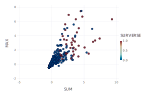

In [25]:
plot(dataframes["4350-01D"],
    x="SUM", y="MAX", color="SURVERSE", Geom.point)

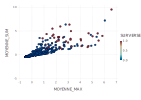

In [26]:
plot(dataframes["4350-01D"],
    x="MOYENNE_MAX", y="MOYENNE_SUM", color="SURVERSE", Geom.point)

#### Construction d'un modèle pour chaque ouvrage

# Estimation des hyperparamètres par validation croisée

In [86]:
# c = Array{Float64}(undef, 5)
# γ = Array{Float64}(undef, 5)
# 
# for i = 2:7
#     push!(c, 2.0^i)
# end
# 
# for i = -10:-5
#     push!(γ, 2.0^i)
# end

#γ = [ 2.0^-4, 2.0^-2, 2.0^1]
#c = [ 2.0^-1, 2.0^4, 2.0^6] #, 2^14]

# γ = [ 2.0^-4, 2.0^-1, 2.0^2]
# c = [ 2.0^7, 2.0^8, 2.0^9]

#γ = [ 2.0^6, 2.0^8, 2.0^12]
#c = [ 2.0^7, 2.0^8, 2.0^12]

# γ = [ 2.0^12, 2.0^14, 2.0^16]
# c = [ 2.0^-2, 2.0^2, 2.0^4]

γ = [ 2.0^-16, 2.0^-15]
c = [ 2.0^15, 2.0^12 ]


weight_factor = 0.45


function cross_validation()
    
    Xs, Ys = shuffleobs( (merged_X[!, 4:end], merged_X[!, 3]) )
    best_params = [0.0, 0.0, 0.0]

    for γᵢ in γ
        for cⱼ in c
            mean_f1_score = 0.0
            
            for ( (train_X, train_Y), (val_X, val_Y)) in kfolds((Xs, Ys), k=5)
                
                model = svmtrain(convert(Matrix, train_X)', convert(Vector, train_Y);
                    weights=Dict([(0, weight_factor), (1, 1.0)]) , gamma=γᵢ, cost=cⱼ)
                
                (predicted_labels, decision_values) = svmpredict(model, convert(Matrix, val_X)')
                mean_f1_score += f_score(val_Y, predicted_labels, beta = 1)
            end
            mean_f1_score = Float64(mean_f1_score / 5)
            # best_params[1] = mean_f1_score
            if mean_f1_score > best_params[1]
                 best_params[1] = Float64(mean_f1_score)
                 best_params[2] = Float64(γᵢ)
                 best_params[3] = Float64(cⱼ)
             end
        end
    end
    
    
    model = svmtrain( convert(Matrix, Xs)', convert(Vector, Ys); 
                      weights=Dict([(0, weight_factor), (1, 1.0)]) , 
                      gamma = best_params[2], cost= best_params[3] )
    #
    #(predicted_labels, decision_values) = svmpredict(best_model, convert(Matrix, X_test)')
    #score = f_score(Y_test, predicted_labels, beta = 1)
    #best_params[ouvrage][1] = score
    
    return best_params, model
    
end

cross_validation (generic function with 1 method)

In [67]:
function compute()
    
    train, test = splitobs(shuffleobs(merged_X), at = 0.9)
    weight_factor = 0.45
    X_train = train[!, 4:end]
    Y_train = train[!, 3]
    
    X_test = test[!, 4:end]
    Y_test = test[!, 3]
    
    model = svmtrain(convert(Matrix, X_train)', convert(Vector, Y_train);
                    weights=Dict([(0, weight_factor), (1, 1.0)]));
    (predicted_labels, decision_values) = svmpredict(model, convert(Matrix, X_test)')
    
    return f_score(Y_test, predicted_labels, beta = 1)
end
    

compute (generic function with 1 method)

In [87]:
#print(compute())
best_params, model = cross_validation()
best_params

3-element Array{Float64,1}:
     0.6476264447282041
     3.0517578125e-5   
 32768.0               

In [30]:
μ = best_params[1]
#for ouvrage in ouvrages
#    print("$ouvrage : a choisi gamma = ")
#    print(Float64(best_params[ouvrage][2]))
#    print(" et c = ")
#    print(Float64(best_params[ouvrage][3]))
#    print("\n")
#    μ += best_params[ouvrage][1]
#end
#μ = μ / 5

print("La moyenne des f1 scores des 5 modèles est de : $μ")

La moyenne des f1 scores des 5 modèles est de : 0.558512002709238

# Création du fichier de prédictions pour soumettre sur Kaggle

Un point important à noter est que ici, nous devons créer 5 DataFrames pour les 5 ouvrages qui sont dans le fichier test, puis construire les variables explicatives pour chaque date. Cette étape est nécessaire car l'algorithme SVM prend en entrée un ensemble d'observations et non une seule observation, puisqu'il doit determiner l'hyperplan de séparation entre les données.

In [88]:
# Chargement du fichier de test
test = CSV.read("data/test.csv")

# initialisation des dataframes pour chaque ouvrage
XY = Dict()
for ouvrage in ouvrages
    XY[ouvrage] =
        DataFrame(Date=Date[], SUM=Float64[], MAX=Float64[], MOYENNE_MAX=Float64[], MOYENNE_SUM=Float64[])
end

# construction des variables explicatives pour chaque ouvrage selon les dates données par le fichier test
for i = 1:size(test, 1)
    push!(XY[test[i, :NO_OUVRAGE]], [ test[i, :DATE] ; dict[test[i, :NO_OUVRAGE]](test, i) ])
end

for ouvrage in ouvrages
    XY[ouvrage][!, :V1] .= ouvrage_to_cat[ouvrage][1]
    XY[ouvrage][!, :V2] .= ouvrage_to_cat[ouvrage][2]
    XY[ouvrage][!, :V3] .= ouvrage_to_cat[ouvrage][3]
    XY[ouvrage][!, :V4] .= ouvrage_to_cat[ouvrage][4]
    XY[ouvrage][!, :V5] .= ouvrage_to_cat[ouvrage][5]
    XY[ouvrage][!, :V6] .= ouvrage_to_cat[ouvrage][6]
end

print(XY["0801-05D"])

# standardisation des dataframes avec les moyennes/variances obtenues précedemment
for ouvrage in ouvrages
    for i = 1:4
        XY[ouvrage][!, i+1] = 
            (XY[ouvrage][!, i+1] .- moyennes_dict[ouvrage][i] )./ variances_dict[ouvrage][i]
    end
end
    
fX = [XY["4350-01D"];
      XY["3260-01D"];
      XY["4240-01D"];
      XY["3350-07D"];
      XY["4380-01D"];
      XY["0801-05D"]]
print(fX)

# prediction pour chaque dataframe avec les modèles construits précedemment

(predicted_labels, decision_values) = svmpredict(model, convert(Matrix, fX[!,2:end])')
insert!(fX, 11, predicted_labels, :SURVERSE)


submission = DataFrame(ID = String[], Surverse=Bool[])

for row in eachrow(test)
    ouvrage = row[:NO_OUVRAGE]
    ID = ouvrage*"_"*string.(row[:DATE])
    ind = findfirst(fX[!, :Date] .== row[:DATE])
    push!(submission, [ID, fX[ind, :SURVERSE]])
end

CSV.write("submission_final.csv",submission)


0×11 DataFrame
283×11 DataFrame
│ Row │ Date       │ SUM        │ MAX        │ MOYENNE_MAX │ MOYENNE_SUM │ V1    │ V2    │ V3    │ V4    │ V5    │ V6    │
│     │ Date       │ Float64    │ Float64    │ Float64     │ Float64     │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │
├─────┼────────────┼────────────┼────────────┼─────────────┼─────────────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ 1   │ 2019-05-03 │ 0.0162597  │ -0.0644839 │ -0.0115744  │ 0.0502857   │ 1     │ 0     │ 0     │ 0     │ 0     │ 0     │
│ 2   │ 2019-05-04 │ -0.388999  │ -0.370608  │ -0.471434   │ -0.431482   │ 1     │ 0     │ 0     │ 0     │ 0     │ 0     │
│ 3   │ 2019-05-07 │ -0.376335  │ -0.339996  │ -0.478851   │ -0.434384   │ 1     │ 0     │ 0     │ 0     │ 0     │ 0     │
│ 4   │ 2019-05-08 │ -0.414328  │ -0.431833  │ -0.501103   │ -0.443091   │ 1     │ 0     │ 0     │ 0     │ 0     │ 0     │
│ 5   │ 2019-05-10 │ 4.46144    │ 1.58859    │ 1.44218     │ 4.01761     │ 1     │ 0     │ 0     │ 0     │ 

│ 68  │ 2019-05-10 │ 4.16981    │ 1.43168    │ 1.45083     │ 4.10873     │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 69  │ 2019-05-15 │ -0.431384  │ -0.463381  │ -0.482606   │ -0.436509   │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 70  │ 2019-05-20 │ 0.236606   │ 0.726811   │ 0.699765    │ 0.158666    │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 71  │ 2019-05-23 │ 3.31964    │ 4.15873    │ 3.85275     │ 3.12566     │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 72  │ 2019-05-24 │ -0.211835  │ -0.105168  │ -0.140536   │ -0.205546   │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 73  │ 2019-05-26 │ -0.295918  │ -0.151389  │ -0.200027   │ -0.309183   │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 74  │ 2019-05-30 │ -0.300589  │ -0.174499  │ -0.162845   │ -0.294378   │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 75  │ 2019-06-02 │ 0.572937   │ 0.264601   │ 0.380004    │ 0.611709    │ 0     │ 1     │ 0     │ 0     │ 0     │ 0     │
│ 76  │ 2019-06-

│ 191 │ 2019-07-03 │ -0.408486  │ -0.439428  │ -0.486659   │ -0.4336     │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 192 │ 2019-07-04 │ -0.408486  │ -0.439428  │ -0.486659   │ -0.4336     │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 193 │ 2019-07-05 │ -0.201311  │ 0.0228989  │ 0.327044    │ -0.00577556 │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 194 │ 2019-07-06 │ -0.339428  │ -0.307334  │ 0.158439    │ -0.103143   │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 195 │ 2019-07-08 │ -0.408486  │ -0.439428  │ -0.486659   │ -0.4336     │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 196 │ 2019-07-11 │ 4.30129    │ 5.2571     │ 6.58742     │ 4.99535     │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 197 │ 2019-07-13 │ -0.256558  │ -0.125706  │ 0.158439    │ -0.0441323  │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 198 │ 2019-07-17 │ -0.408486  │ -0.439428  │ 0.686246    │ 0.0384822   │ 0     │ 0     │ 0     │ 1     │ 0     │ 0     │
│ 199 │ 2019-07-

┌ Warning: `insert!(df::DataFrame, col_ind::Int, item, name::Symbol; makeunique::Bool=false)` is deprecated, use `insertcols!(df, col_ind, name => item; makeunique=makeunique)` instead.
│   caller = top-level scope at In[88]:46
└ @ Core In[88]:46


"submission_final.csv"

In [89]:
print(filter(x-> x.Surverse == 1, submission))


45×2 DataFrame
│ Row │ ID                  │ Surverse │
│     │ String              │ Bool     │
├─────┼─────────────────────┼──────────┤
│ 1   │ 3260-01D_2019-05-10 │ 1        │
│ 2   │ 3260-01D_2019-05-23 │ 1        │
│ 3   │ 3350-07D_2019-05-01 │ 1        │
│ 4   │ 3350-07D_2019-05-10 │ 1        │
│ 5   │ 3350-07D_2019-05-14 │ 1        │
│ 6   │ 3350-07D_2019-05-19 │ 1        │
│ 7   │ 3350-07D_2019-05-23 │ 1        │
│ 8   │ 4240-01D_2019-05-10 │ 1        │
│ 9   │ 4240-01D_2019-05-23 │ 1        │
│ 10  │ 4350-01D_2019-05-10 │ 1        │
│ 11  │ 4350-01D_2019-05-23 │ 1        │
│ 12  │ 4380-01D_2019-05-10 │ 1        │
│ 13  │ 3260-01D_2019-06-11 │ 1        │
│ 14  │ 3260-01D_2019-06-29 │ 1        │
│ 15  │ 3350-07D_2019-06-11 │ 1        │
│ 16  │ 3350-07D_2019-06-29 │ 1        │
│ 17  │ 3350-07D_2019-06-30 │ 1        │
│ 18  │ 4240-01D_2019-06-11 │ 1        │
│ 19  │ 4240-01D_2019-06-20 │ 1        │
│ 20  │ 4240-01D_2019-06-29 │ 1        │
│ 21  │ 4240-01D_2019-06-30 │ 1        │
│

In [80]:
sb = CSV.read("sampleSubmission.csv")
print(filter(x-> x.Surverse == 1, sb))

60×2 DataFrame
│ Row │ ID                  │ Surverse │
│     │ String              │ Bool     │
├─────┼─────────────────────┼──────────┤
│ 1   │ 3260-01D_2019-05-10 │ 1        │
│ 2   │ 3260-01D_2019-05-23 │ 1        │
│ 3   │ 3350-07D_2019-05-01 │ 1        │
│ 4   │ 3350-07D_2019-05-09 │ 1        │
│ 5   │ 3350-07D_2019-05-10 │ 1        │
│ 6   │ 3350-07D_2019-05-14 │ 1        │
│ 7   │ 3350-07D_2019-05-19 │ 1        │
│ 8   │ 3350-07D_2019-05-20 │ 1        │
│ 9   │ 3350-07D_2019-05-23 │ 1        │
│ 10  │ 4240-01D_2019-05-10 │ 1        │
│ 11  │ 4240-01D_2019-05-23 │ 1        │
│ 12  │ 4350-01D_2019-05-10 │ 1        │
│ 13  │ 4350-01D_2019-05-23 │ 1        │
│ 14  │ 4380-01D_2019-05-10 │ 1        │
│ 15  │ 3260-01D_2019-06-11 │ 1        │
│ 16  │ 3260-01D_2019-06-29 │ 1        │
│ 17  │ 3350-07D_2019-06-02 │ 1        │
│ 18  │ 3350-07D_2019-06-11 │ 1        │
│ 19  │ 3350-07D_2019-06-14 │ 1        │
│ 20  │ 3350-07D_2019-06-15 │ 1        │
│ 21  │ 3350-07D_2019-06-25 │ 1        │
│